In [7]:
#Please install and run these packages
# If needed, install with:
# install.packages(c("tidyverse", "readr", "tidymodels", "repr"))
library(tidyverse)
library(readr)
library(tidymodels)
library(repr)

## 1. Data description

We are analyzing two linked datasets from a UBC Minecraft research server:

- **players.csv** (196 rows, 7 columns)  
  - `hashedEmail` (character): anonymized player ID; key linking files.  
  - `name` (character): first name; not used as a predictor.  
  - `gender` (categorical: Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say).  
  - `Age` (numeric, years; 2 missing).  
  - `experience` (categorical: Beginner, Amateur, Regular, Veteran, Pro).  
  - `played_hours` (numeric): total hours of recorded gameplay.  
  - `subscribe` (logical): newsletter subscription.

- **sessions.csv** (1535 rows, 5 columns)  
  - `hashedEmail` (character): player ID, matches players.csv.  
  - `start_time`, `end_time` (character): session start/end (day/month/year hour:minute).  
  - `original_start_time`, `original_end_time` (numeric): timestamps (milliseconds since Unix epoch).

Main issues:

- Many players have **no matching session rows**, so they appear to have never started a logged session.  
- `played_hours` is almost the sum of session durations, so it is highly collinear with total server time.  
- A few sessions have missing end times, so their durations are unknown.  
- Activity is extremely skewed (most players have 0–1 sessions, a few have hundreds), giving heavy tails and outliers.  
- Demographic variables are self-reported in a convenience sample, so bias is possible.

## 2. Questions

- **Broad question (Q2):** Which kinds of players are most likely to generate large amounts of gameplay data on the server?  
- **Specific predictive question:** *Can basic player characteristics (age, gender, experience level, newsletter subscription) predict whether a player becomes a “high-activity” user who produces many sessions on the server?*

I will define **HighActivity** = 1 if a player has at least 2 logged sessions (upper quartile), and 0 otherwise. Explanatory variables come from players.csv. sessions.csv is used only to count sessions.

## 3. Exploratory analysis plan

I will:

- Load both CSVs, join by `hashedEmail`, and compute per-player summaries: number of sessions and total minutes played.  
- Tidy to one row per player, replacing missing session counts with 0.  
- Compute means for quantitative variables in players.csv (`Age`, `played_hours`) and report them in a table.  
- Create plots: histogram of session counts; barplots of session counts by experience and gender; scatterplot of age versus session count.  
- Use these to see which groups appear more active and to check skewness, outliers, and missingness.

In [53]:
players_url  <- "https://raw.githubusercontent.com/Elijah-Lal/Individual-Project-Planning-Stage/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/Elijah-Lal/Individual-Project-Planning-Stage/refs/heads/main/sessions.csv"

dir.create("data", showWarnings = FALSE)

download.file(players_url,  destfile = "data/players.csv", mode = "wb")
download.file(sessions_url, destfile = "data/sessions.csv", mode = "wb")

players  <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Using the session counts, I define a binary variable `HighActivity`, which equals `TRUE` if a player has at least 2 sessions, and `FALSE` otherwise. This variable represents whether a player contributes more than a minimal amount of gameplay data.

In [54]:
per_player <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    n_sessions = n(),
    .groups = "drop"
  )

players_joined <- players |>
  left_join(per_player, by = "hashedEmail") |>
  mutate( n_sessions   = replace_na(n_sessions, 0),
         HighActivity = n_sessions >= 2)

glimpse(players_joined)

Rows: 196
Columns: 9
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
$ n_sessions   <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37, 2…
$ HighActivity <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…


In [55]:
# Categorical summaries for experience, gender, and subscription status
players_joined |>
  count(experience)

players_joined |>
  count(gender)

players_joined |>
  count(subscribe)

# Mean of each numeric variable in players.csv
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(
    everything(),
    names_to = "variable",
    values_to = "mean"
  ) |>
  mutate(mean = round(mean, 2))

players_means

experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


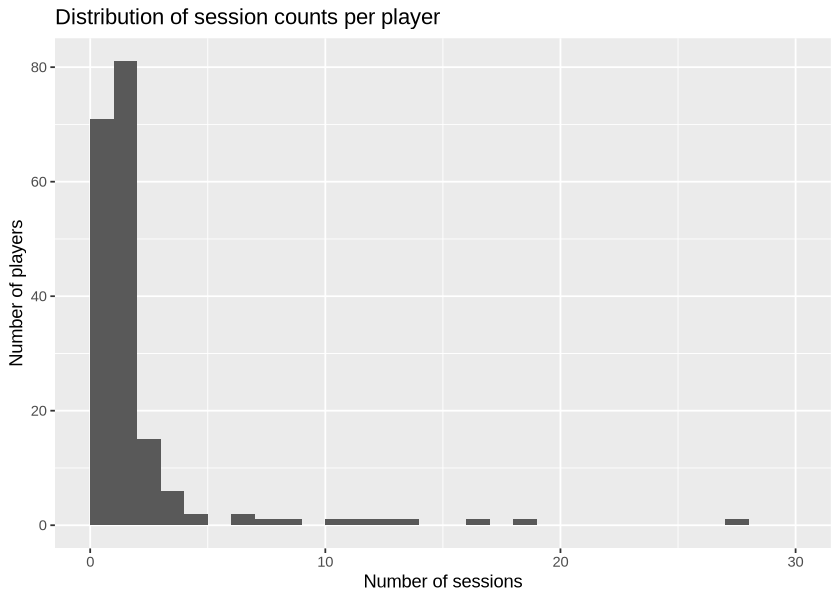

In [49]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(players_joined, aes(x = n_sessions)) +
  geom_histogram(binwidth = 1, boundary = 0, closed = "left") +
  coord_cartesian(xlim = c(0, 30)) +  # focus on players with up to 30 sessions
  labs(
    title = "Distribution of session counts per player",
    x = "Number of sessions",
    y = "Number of players"
  ) 

Most players have between 0 and 2 sessions, while only a small number have more than 10 sessions. This supports the idea that a minority of players contribute a large amount of data.

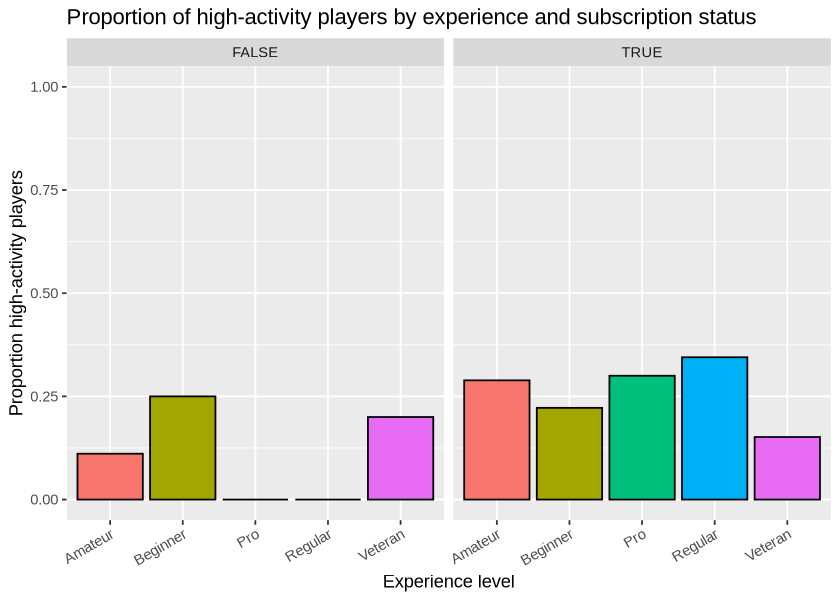

In [50]:
# Computing the proportion of high-activity players by experience and subscription
activity_by_exp_sub <- players_joined |>
  group_by(experience, subscribe) |>
  summarise (
    prop_high = mean(HighActivity),
    .groups = "drop"
  )

ggplot(activity_by_exp_sub, aes(x = experience, y = prop_high, fill = experience)) +
  geom_bar(stat = "identity", color = "black") +
  facet_grid(. ~ subscribe) +
  ylim(0, 1) +
  labs(
    title = "Proportion of high-activity players by experience and subscription status",
    x = "Experience level",
    y = "Proportion high-activity players"
  ) + 
  theme(
    legend.position = "none",
    axis.text.x = element_text(angle = 30, hjust = 1)
  )

It appears that subscription status plays a role in the proportion of high activity players within the pro and regular experience levels.

gender,prop_high,n_players
<chr>,<dbl>,<int>
Agender,0.5000000,2
Female,0.2162162,37
Male,0.2258065,124
Non-binary,0.2666667,15
Other,0.0000000,1
Prefer not to say,0.2727273,11
Two-Spirited,0.0000000,6


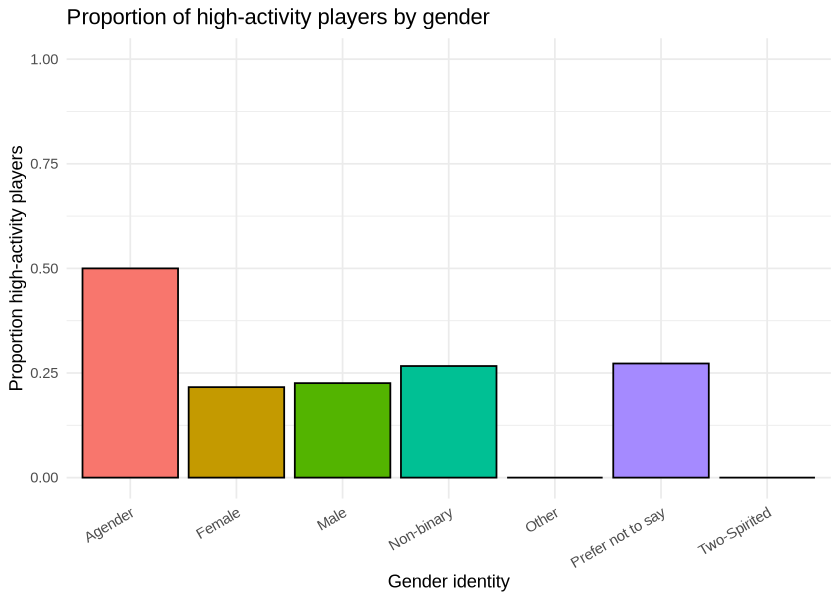

In [51]:
# Computing proportion of high-activity players by gender
activity_by_gender <- players_joined |>
  group_by(gender) |>
  summarise(
    prop_high = mean(HighActivity),
    n_players = n(),
    .groups = "drop"
  )

activity_by_gender

ggplot(activity_by_gender, aes(x = gender, y = prop_high, fill = gender)) +
  geom_bar(stat = "identity", color = "black") +
  ylim(0, 1) +
  labs(
    title = "Proportion of high-activity players by gender",
    x = "Gender identity",
    y = "Proportion high-activity players"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text.x = element_text(angle = 30, hjust = 1)
  )

For the two largest groups, Male and Female players, the proportion of high-activity users is very similar (both around 22–23%). Some smaller gender categories show higher or lower proportions, but these groups have only a few players, so their proportions are unstable and should be interpreted cautiously.
Taken together, this suggests that, in this dataset, player experience and behaviour are likely more important for predicting high activity than either age or gender.

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


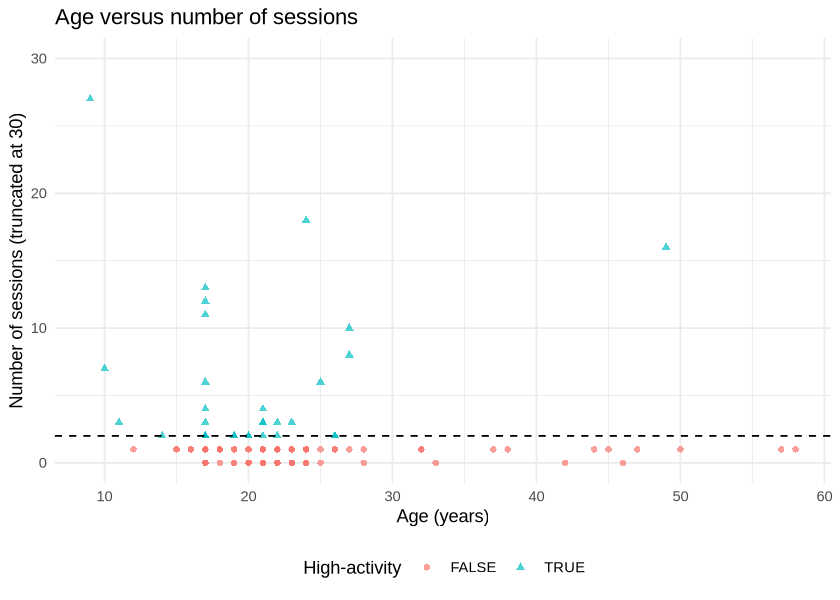

In [56]:
ggplot(players_joined, aes(x = Age, y = n_sessions, color = HighActivity, shape = HighActivity)) +
  geom_point(alpha = 0.7) +
  geom_hline(yintercept = 2, linetype = "dashed") +
  ylim(0, 30) +
  labs(
    title = "Age versus number of sessions",
    x = "Age (years)",
    y = "Number of sessions (truncated at 30)",
    color = "High-activity",
    shape = "High-activity"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

Players are mostly clustered around age 21, with only a few much younger or older players.

## 4. Methods and plan (no modelling yet)

For the modelling phase (later in the project), I plan to use a **logistic regression** model with `HighActivity` as the binary response variable and the following predictors from `players.csv`:

- `Age` (numeric)
- `gender` (categorical)
- `experience` (categorical)
- `subscribe` (logical)

**Why this method is appropriate:**

- Logistic regression is designed for binary outcomes and can handle a mix of numeric and categorical predictors.
- The model coefficients can be interpreted in terms of odds ratios, which helps explain which player characteristics are associated with being high-activity.

**Key assumptions:**

- Observations (players) are independent.
- The log-odds of `HighActivity` are approximately linear in numeric predictors.
- No extreme multicollinearity among predictors.

**Limitations:**

- The sample size is modest, and the high-activity class may be imbalanced.
- The model is mostly linear and may miss more complex relationships.

**Planned data splitting and evaluation:**

- Split the data into a training set (80%) and a test set (20%), stratified by `HighActivity`.
- Use 5-fold cross-validation on the training set to select and tune the final model.
- Evaluate predictive performance on the test set using metrics such as accuracy and ROC AUC.

## 5. GitHub repository

The code for this project is in: 
https://github.com/Elijah-Lal/Individual-Project-Planning-Stage